## Inference With Trained Model

In this notebook, we perform inference via the probability flow (ODE) and reverse-time SDE using a pretrained model $s_\theta$.

In [1]:
import sys
import os

sys.path.append(os.path.join(os.path.abspath(''), 'github', 'smdp', 'heat-diffusion'))

from dataloader import *
from train import * 
from optimizers.EmbeddedPhysics import *

#### Setup simulation parameters

First, we setup the environment and define the simulation parameters.

In [2]:
resolution = 32
noise_scaling = 0.1
step_size = 0.01
t1 = 0.2

params = {'resolution': resolution, 
          'sample_key': jax.random.PRNGKey(0), 
          't1': t1, 
          't0': 0,
          'inference' : {
                'noise' : noise_scaling
         },
          'time_format' : 'linear',
          'num_steps' : 32
         }

DT = step_size
NSTEPS = int(t1 / DT)

The initial states are generated using the code in the `data/gaussian_random_fields.ipynb`.

In [3]:
from dataloader import DataLoader

DATA_ROOT = os.path.join(os.path.abspath(''), 'github', 'smdp', 'heat-diffusion', 'data', 'files')
NUM_ELEMENTS = 4

dataset_name = '32/2d_gaussian_random_field_4'

params['file'] = f'{DATA_ROOT}/{dataset_name}.h5'
params['batch_size'] = NUM_ELEMENTS

with h5py.File(params['file'], 'r') as f:
    train_keys = list(f.keys())
    train_keys = list(zip([params['file']] * len(train_keys), train_keys))
    
generator = DataLoader([params['file']], train_keys[:NUM_ELEMENTS], params['batch_size'], name='train', shuffle=False)

data = generator.__getitem__(0)[:, :, :, 0]

Length: 4


In [4]:
data_mean, data_std, data_min, data_max = generator.get_norm()
generator.set_mean_and_std(data_mean, data_std)

params['data_mean'] = data_mean
params['data_std'] = data_std

### Load network and weights

In [5]:
shape = (1, resolution, resolution)
forward_fn, params_ = get_model(shape)
rng = jax.random.PRNGKey(2022)

Tracing encoder decoder model...


In [6]:
WEIGHT_PATH = os.path.join(os.path.abspath(''), 'github', 'smdp', 'heat-diffusion', 'weights', 'ojnepihc_r32_0080.p')

with open(WEIGHT_PATH, 'rb') as file:
    model_weights = pickle.load(file)

In [7]:
forward_fn_jit = jax.jit(forward_fn)
_ = forward_fn_jit(model_weights, rng, jnp.ones((1, 1, 32, 32)), jnp.ones((1,)), rng)

Tracing encoder decoder model...


## Inference

In [8]:
from evaluation.embedded_physics_eval import predict
import jax.random as jr

keys = [key[1] for key in generator.keys]

Probability flow solution

In [9]:
pred_probability_flow = predict(generator, params, forward_fn_jit, model_weights, keys, jr.PRNGKey(0), version=3, realizations=1)


0it [00:00, ?it/s]

Tracing encoder decoder model...


32it [00:02, 11.32it/s]


Reverse-time SDE solution

In [10]:
pred_reverse_sde = predict(generator, params, forward_fn_jit, model_weights, keys, jr.PRNGKey(0), version=0, realizations=3)

32it [00:00, 78.93it/s]
32it [00:00, 81.61it/s]
32it [00:00, 76.00it/s]


## Visualize results

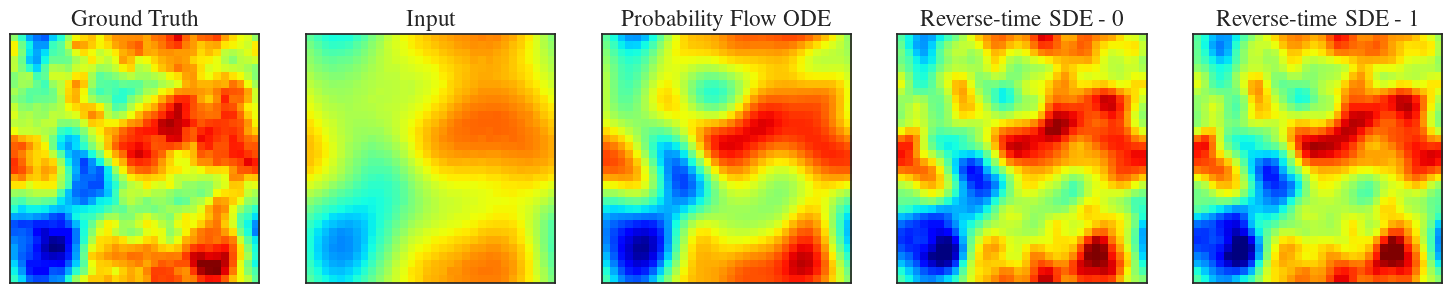

In [11]:
idx = 0

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

gt = (generator.load((list(generator.h5files.keys())[0], keys[idx]), transform=False)[...,0] - params['data_mean']) / params['data_std']

vmin = np.min(gt)
vmax = np.max(gt)

axes[0].imshow(gt, cmap='jet')
axes[0].set_title('Ground Truth')
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(pred_probability_flow['input'][idx], cmap='jet', vmin=vmin, vmax=vmax)
axes[1].set_title('Input')
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].imshow(pred_probability_flow['prediction_0'][idx], cmap='jet', vmin=vmin, vmax=vmax)
axes[2].set_title('Probability Flow ODE')
axes[2].set_xticks([])
axes[2].set_yticks([])

axes[3].imshow(pred_reverse_sde['prediction_0'][idx], cmap='jet', vmin=vmin, vmax=vmax)
axes[3].set_title('Reverse-time SDE - 0')
axes[3].set_xticks([])
axes[3].set_yticks([])

axes[4].imshow(pred_reverse_sde['prediction_1'][idx], cmap='jet', vmin=vmin, vmax=vmax)
axes[4].set_title('Reverse-time SDE - 1')
axes[4].set_xticks([])
axes[4].set_yticks([])

# set axis grids on 
for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()
